In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import inv, hankel
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score 

sys.path.append('./../../tensor-dynamic-univariate-ts-pytorch/')
from tensordynamicmodel.visuals import plot_phase_trajectory, delay_embedding_matrix
from tensordynamicmodel.utils import delay_embedding_matrix, diag_mean, prepare_time_series, lorenz

In [2]:
# plt.rcParams['font.family'] = 'DejaVu Serif'
# plt.rcParams.update({"text.usetex": False})

In [3]:
def moving_average_simple(data, window_size):
    """
    Простая реализация скользящего среднего
    """
    moving_avg = []
    for i in range(len(data)):
        if i < window_size - 1:
            # Для первых элементов недостаточно данных
            moving_avg.append(np.nan)
        else:
            # Вычисляем среднее для окна
            window = data[i - window_size + 1:i + 1]
            moving_avg.append(np.mean(window))
    return np.array(moving_avg)
    
def make_ts(person, activity):
    pdf_data_all = pd.read_csv(f'./../data/A_DeviceMotion_data/{activity}/sub_{person}.csv').reset_index(drop=True)
    data_list = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
    data_list_short = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
    pdf_data_all = pdf_data_all[data_list_short]
    xyz = pdf_data_all[data_list_short].to_numpy()
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    return (x**2 + y**2 + z**2)**0.5

def acc_ts_alignment(x, trashhold = 2):
    x = (x - x.mean())/(x.var()**.5)
    i_peak, _ = find_peaks(x)
    i_min_peak = [i for i in i_peak if x[i] >= trashhold]
    return i_min_peak[0]


In [4]:
def prepare_ts(person, activity, global_start_point, global_end_point, person_start_point_map_500):
    ts = make_ts(person, 'wlk_15')[global_start_point+person_start_point_map_500[person]:global_end_point]
    # ts = moving_average_simple(ts, 20)[20:]
    return ts

In [5]:
global_start_point = 500
global_end_point = None
person_start_point_map_500 = {
    1: 5-1,
    2: 6,
    3: 9,
    4: 45,
    5: 13-4,
    6: 16,
    7: 63,
    8: 68,
    9: 69,
    10: 47,
    11: 29,
    12: 40,
    13: 44-5,
    14: 13,
    15: 49,
    16: 3-1,
    17: 13,
    18: 8,
    19: 26+10,
    20: 40,
    21: 46,
    22: 16,
    23: 47-8,
    24: 34-6
}

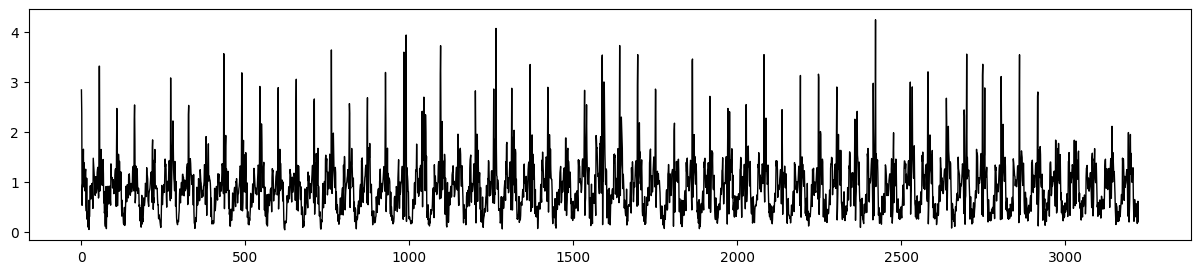

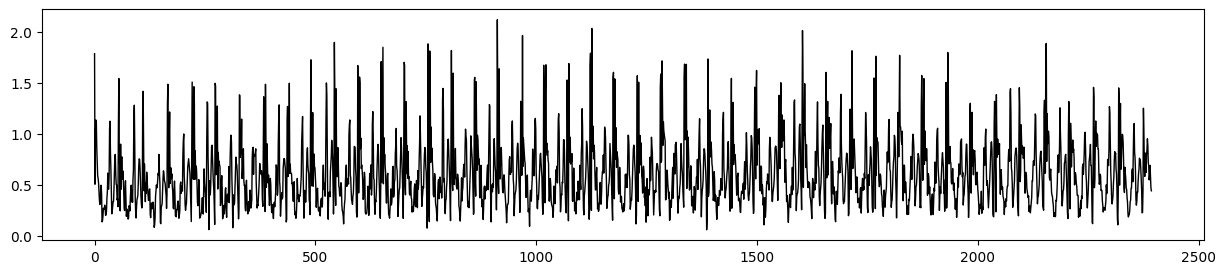

In [6]:
ts_1 = prepare_ts(4, 'wlk_7', global_start_point, global_end_point, person_start_point_map_500)
ts_2 = prepare_ts(7, 'wlk_7', global_start_point, global_end_point, person_start_point_map_500)

plt.figure(figsize=(15,3))
plt.plot(ts_1[:], color = 'black', ls = '-', lw = 1)
plt.show()

plt.figure(figsize=(15,3))
plt.plot(ts_2[:], color = 'black', ls = '-', lw = 1)
plt.show()

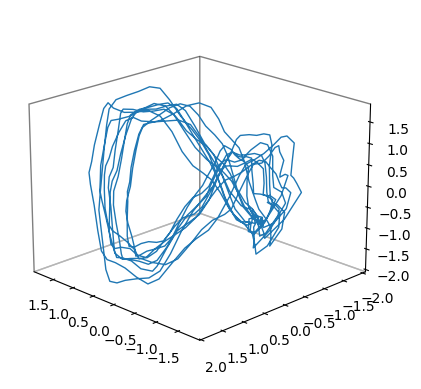

In [7]:
X = delay_embedding_matrix(ts_1, 50)
model = PCA(3).fit(X)
W = model.components_.T
s = X @ W
s =(s-s[:500,:].mean(axis=0))/s[:500,:].var(axis=0)**0.5
ax = plot_phase_trajectory(s[:500,:], rotation=(0, 0, 0))

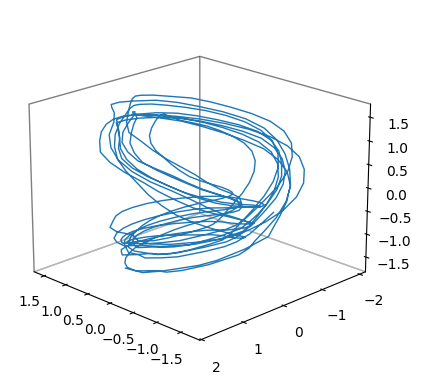

In [8]:
s = PCA(3).fit_transform(delay_embedding_matrix(ts_2, 50))
s =(s-s.mean(axis=0))/s.var(axis=0)**0.5
ax = plot_phase_trajectory(s[:500,:], rotation=(0, 0, 0))

## Phase space reconstruction

In [9]:
from numpy.linalg import inv

In [10]:
class UnionDynamicRegression():
    
    def __init__(self, nlags, p):
        self.nlags = nlags
        self.p = p
        
    def _delay_embedding_matrix(self, s, nlags, fit_intercept=False):
        N = len(s)
        delay_embedding_matrix = hankel(s[:N - nlags + 1], s[N - nlags: N])
        if fit_intercept:
            delay_embedding_matrix = np.hstack((np.ones((delay_embedding_matrix.shape[0], 1)), delay_embedding_matrix))
        return delay_embedding_matrix

    def _make_space(self, list_ts, nlags, X_theta):
        union_X = np.array([])
        for i, ts in enumerate(list_ts):
            
            X = self._delay_embedding_matrix(ts, nlags)
            X = np.concatenate((X,np.ones((X.shape[0],X_theta.shape[1]))*X_theta[i,:]), axis=1)
            if len(union_X) != 0:
                union_X = np.append(union_X, X, axis=0)
            else:
                union_X = X
        return union_X
        

    def fit(self, list_ts, X_theta):
        self.X_theta = np.array(X_theta)
        union_X = self._make_space(list_ts, nlags, X_theta)
        self.model = PCA(self.p).fit(union_X)
        return self

    def transform(self, ts, x_theta):
        X = self._delay_embedding_matrix(ts, nlags)
        X = np.concatenate((X,np.ones((X.shape[0], len(x_theta)))*x_theta), axis=1)
        S = self.model.transform(X)
        return S
    def inverse_transform(self, S, x_theta):
        union_X = self.model.inverse_transform(S)
        X = union_X[:,:-len(x_theta)]
        return X

In [11]:
import numpy as np
from scipy.linalg import hankel, inv
from sklearn.decomposition import PCA
from typing import List, Tuple, Dict, Optional, Union, Any
from sklearn.linear_model import Lasso, LinearRegression

In [12]:
import numpy as np
from scipy.linalg import hankel, inv
from sklearn.decomposition import PCA
from typing import List, Tuple, Dict, Optional, Union, Any


class NearDynamicRegression:
    
    def __init__(self, nlags: int, p: int) -> None:
        self.nlags = nlags
        self.p = p
        self.list_model = []
        self.X_theta = None
    def _delay_embedding_matrix(self, s: np.ndarray, nlags: int, fit_intercept: bool = False) -> np.ndarray:

        N = len(s)
        delay_embedding_matrix = hankel(s[:N - nlags + 1], s[N - nlags: N])
        
        if fit_intercept:
            delay_embedding_matrix = np.hstack((
                np.ones((delay_embedding_matrix.shape[0], 1)), 
                delay_embedding_matrix
            ))
            
        return delay_embedding_matrix

    def _find_nearest_dynamic_system(self, x_theta: np.ndarray) -> Tuple[int, np.ndarray]:
            
        distances = np.sum((self.X_theta - x_theta)**2, axis=1)**0.5
        i_nn = np.argmin(distances)
        x_theta_nn = self.X_theta[i_nn, :]
        
        return i_nn, x_theta_nn

    def fit(self, list_ts: List[np.ndarray], X_theta: np.ndarray) -> 'NearDynamicRegression':
        
        self.X_theta = X_theta
        
        for ts in list_ts:
            X = self._delay_embedding_matrix(ts, nlags)
            model = PCA(self.p).fit(X)
            self.list_model.append(model)
        
        return self

    def transform(self, ts: np.ndarray, x_theta: np.ndarray) -> np.ndarray:

        i_nn, x_theta_nn = self._find_nearest_dynamic_system(x_theta)
        X_ts = self._delay_embedding_matrix(ts, self.nlags)
        S = self.list_model[i_nn].transform(X_ts)
        return S
            
    def inverse_transform(self, S: np.ndarray, x_theta: np.ndarray) -> np.ndarray:

        i_nn, x_theta_nn = self._find_nearest_dynamic_system(x_theta)
        X = self.list_model[i_nn].inverse_transform(S)
        return X

In [13]:
class MultilinearDynamicRegression:
    
    def __init__(self, nlags: int, p: int) -> None:
        self.nlags = nlags
        self.p = p
        self.min_length = np.inf
        
    def _delay_embedding_matrix(self, s: np.ndarray, nlags: int, fit_intercept: bool = False) -> np.ndarray:
        N = len(s)
        delay_embedding_matrix = hankel(s[:N - nlags + 1], s[N - nlags: N])
        
        if fit_intercept:
            delay_embedding_matrix = np.hstack((
                np.ones((delay_embedding_matrix.shape[0], 1)), 
                delay_embedding_matrix
            ))
            
        return delay_embedding_matrix

    def _make_subspace(self, list_ts: List[np.ndarray], nlags: int) -> List[np.ndarray]:
        
        list_X = []
        
        for ts in list_ts:
            X = self._delay_embedding_matrix(ts, nlags, fit_intercept=True)
            list_X.append(X)
            cur_min_length = X.shape[0]
            
            if cur_min_length < self.min_length:
                self.min_length = cur_min_length
            
        list_X = [X[:self.min_length, :] for X in list_X]
        
        return list_X
        
    def _fit_main_model(self, list_X: List[np.ndarray], X_theta: np.ndarray) -> None:
        #######################################################################################################################################
        n_series = len(list_X)
        matrix_X = np.vstack(list_X)
        
        list_theta_times_X = []
        for i, X in enumerate(list_X):
            theta_times_X = np.einsum('ij,k->ijk', X, X_theta[i, :])
            theta_times_X = theta_times_X.reshape((self.min_length, -1))
            list_theta_times_X.append(theta_times_X)
        
        matrix_theta_times_X = np.vstack(list_theta_times_X)
            
        self.phase_model = PCA(n_components=self.p).fit(matrix_theta_times_X)
        matrix_S = self.phase_model.transform(matrix_theta_times_X)

        self.W = self.phase_model.components_.T
        # #######################################################################################################################################
        
        list_S = [matrix_S[i:i+self.min_length] for i in range(0,matrix_S.shape[0],self.min_length)]
        list_theta_times_S = []
        for i, S in enumerate(list_S):
            theta_times_S = np.einsum('ij,k->ijk', S, X_theta[i, :])
            theta_times_S = theta_times_S.reshape((self.min_length, -1))
            # theta_times_S = np.concatenate((S,np.ones((S.shape[0],X_theta.shape[1]))*X_theta[i,:]), axis=1)
            list_theta_times_S.append(theta_times_S)

        matrix_theta_times_S = np.vstack(list_theta_times_S)
        self.restore_model = LinearRegression(fit_intercept=False).fit(X=matrix_theta_times_S, y = matrix_X) 
        # self.W_inv = inv(matrix_theta_times_S.T@matrix_theta_times_S)@matrix_theta_times_S.T@matrix_X
        
        
    def params(self) -> Dict[str, Any]:
        return {
            'phase_space_model': self.W,
            # 'inverse_phase_space_model': self.W_inv,
            'nlags': self.nlags,
            'p': self.p
        }

    def fit(self, list_ts: List[np.ndarray], X_theta: np.ndarray) -> 'MultilinearDynamicRegression':
        X_theta = np.hstack((
            np.ones((X_theta.shape[0], 1)), 
            np.array(X_theta)
        ))
        self.dim_theta = X_theta.shape[1]
        
        list_X = self._make_subspace(list_ts, self.nlags)
        self._fit_main_model(list_X, X_theta)
        
        return self

    def transform(self, ts: np.ndarray, x_theta: np.ndarray) -> np.ndarray:
        x_theta = np.hstack([1, x_theta])
        X = self._delay_embedding_matrix(ts, self.nlags, fit_intercept=True)
        theta_times_X = np.einsum('ij,k->ijk', X, x_theta).reshape((X.shape[0], -1))
        S = theta_times_X @ self.W
        return S
            
    def inverse_transform(self, S: np.ndarray, x_theta: np.ndarray) -> np.ndarray:
        x_theta = np.hstack([1, x_theta])
        theta_times_S = np.einsum('ij,k->ijk', S, x_theta).reshape((S.shape[0], -1))
        # theta_times_S = np.concatenate((S,np.ones((S.shape[0],x_theta.shape[0]))*x_theta), axis=1)
        X = self.restore_model.predict(theta_times_S)
        # X = self.phase_model.inverse_transform(S)
        return X[:,1:]

In [14]:
global_start_point = 500
global_end_point = None
person_start_point_map_500 = {
    1: 5-1,
    2: 6,
    3: 9,
    4: 45,
    5: 13-4,
    6: 16,
    7: 63,
    8: 68,
    9: 69,
    10: 47,
    11: 29,
    12: 40,
    13: 44-5,
    14: 13,
    15: 49,
    16: 3-1,
    17: 13,
    18: 8,
    19: 26+10,
    20: 40,
    21: 46,
    22: 16,
    23: 47-8,
    24: 34-6
}

# Точность на новых временных рядах

In [15]:
list_ts = []
for person in range(1, 25):
    print(person, end=' ')
    ts = make_ts(person, 'wlk_7')[global_start_point+person_start_point_map_500[person]:global_end_point]
    ts = (ts - ts.mean())/(ts.var()**.5)
    list_ts.append(ts)

theta_all =  pd.read_csv('./../data/A_DeviceMotion_data/data_subjects_info.csv').drop(columns=['code']).to_numpy()
# theta_all = ((theta_all - theta_all.mean())/(theta_all.var()**.5))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [16]:
n_ts_train = 15
list_ts_train = list_ts[:n_ts_train]
theta_all_train = theta_all[:n_ts_train,:]

list_ts_test = list_ts[n_ts_train:]
theta_all_test = theta_all[n_ts_train:,:]

# theta_all_test = ((theta_all_test - theta_all_train.mean(axis=0))/(theta_all_train.var(axis=0)**.5))
# theta_all_train = ((theta_all_train - theta_all_train.mean(axis=0))/(theta_all_train.var(axis=0)**.5))

In [17]:
nlags = 50
p = 6
lin_model = UnionDynamicRegression( nlags, p).fit(list_ts_train, theta_all_train)
mlin_model = MultilinearDynamicRegression( nlags, p).fit(list_ts_train, theta_all_train)

In [18]:
i = 5
ts_i, theta_i = list_ts_test[i], theta_all_test[i]
X_true = delay_embedding_matrix(ts_i, nlags)

tmp_model = PCA(mlin_model.params()['p']).fit(X_true)

S_true = tmp_model.transform(X_true)
S_union =  lin_model.transform(ts_i, theta_i)
S_suggest =  mlin_model.transform(ts_i, theta_i)

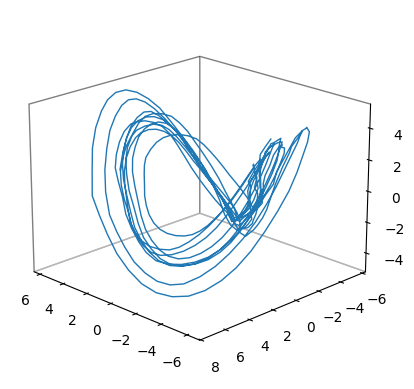

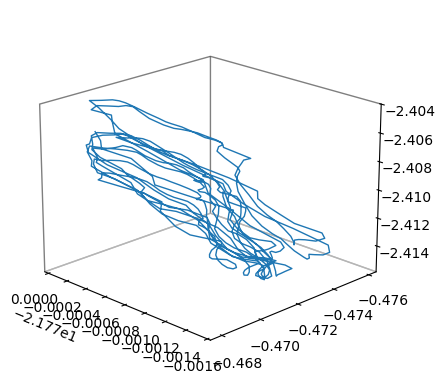

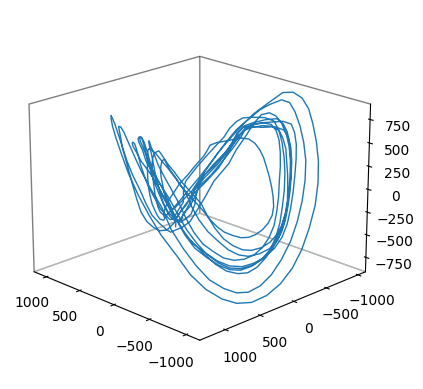

In [19]:
ax = plot_phase_trajectory(S_true[:500,:3], rotation=(0, 0, 0))
ax = plot_phase_trajectory(S_union[:500,:3], rotation=(0, 0, 0))
ax = plot_phase_trajectory(S_suggest[:500,:3], rotation=(0, 0, 0))

In [44]:
def make_experimnt_2(n_ts_train, nlags, p):
    list_ts_train = list_ts[:n_ts_train]
    theta_all_train = theta_all[:n_ts_train,:]
    
    theta_all_test = theta_all[n_ts_train:,:]
    list_ts_test = list_ts[n_ts_train:]
    
    near_model = NearDynamicRegression( nlags, p).fit(list_ts_train, theta_all_train)
    mlin_model = MultilinearDynamicRegression( nlags, p).fit(list_ts_train, theta_all_train)
    
    r2_mean = []
    for ts_i, theta_i in zip(list_ts_test, theta_all_test):
    
        
        X_true = delay_embedding_matrix(ts_i, nlags)
        
        S_near =  near_model.transform(ts_i, theta_i)
        S_suggest = mlin_model.transform(ts_i, theta_i)
        
        X_rec_2 = near_model.inverse_transform(S_near, theta_i)
        X_rec_4 = mlin_model.inverse_transform(S_suggest, theta_i)
        
        
        a_2 = round(r2_score(X_true, X_rec_2), 4)
        a_4 = round(r2_score(X_true, X_rec_4), 4)

        r2_mean.append(a_4-a_2)
    return np.mean(r2_mean)

In [78]:
for p in range(3,11):
    for nlags in range(10,55,5):
        for n_ts_train in range(5,10):
            r2_mean_lags = make_experimnt_2(n_ts_train, nlags, p)
            if r2_mean_lags>0.01:
                print(f'p {p} nlags {nlags} n_ts_train {n_ts_train} mean r2 {round(r2_mean_lags,4)}')

p 3 nlags 10 n_ts_train 7 mean r2 0.0103
p 3 nlags 15 n_ts_train 7 mean r2 0.0148
p 3 nlags 20 n_ts_train 7 mean r2 0.0276
p 3 nlags 20 n_ts_train 9 mean r2 0.0109
p 3 nlags 25 n_ts_train 7 mean r2 0.0265
p 3 nlags 25 n_ts_train 8 mean r2 0.0102
p 3 nlags 25 n_ts_train 9 mean r2 0.0139
p 3 nlags 30 n_ts_train 7 mean r2 0.0135
p 3 nlags 40 n_ts_train 7 mean r2 0.0247
p 3 nlags 45 n_ts_train 5 mean r2 0.0119
p 3 nlags 45 n_ts_train 6 mean r2 0.0173
p 3 nlags 45 n_ts_train 7 mean r2 0.0119
p 4 nlags 20 n_ts_train 9 mean r2 0.01
p 4 nlags 25 n_ts_train 7 mean r2 0.0164
p 4 nlags 30 n_ts_train 7 mean r2 0.0159
p 4 nlags 30 n_ts_train 8 mean r2 0.0141
p 4 nlags 30 n_ts_train 9 mean r2 0.0173
p 4 nlags 35 n_ts_train 7 mean r2 0.0146
p 4 nlags 35 n_ts_train 9 mean r2 0.017
p 4 nlags 50 n_ts_train 7 mean r2 0.0206
p 5 nlags 15 n_ts_train 7 mean r2 0.0162
p 5 nlags 15 n_ts_train 9 mean r2 0.0122
p 5 nlags 30 n_ts_train 7 mean r2 0.0127
p 6 nlags 20 n_ts_train 7 mean r2 0.0169
p 7 nlags 30 n_ts_t

In [70]:
def reconstruct_from_hankel(X):
    n_samples, n_cols = X.shape
    ts_length = n_samples + n_cols - 1
    reconstructed = np.zeros(ts_length)
    counts = np.zeros(ts_length)
    
    # Восстанавливаем, усредняя диагонали матрицы Ханкеля
    for i in range(n_samples):
        for j in range(n_cols):
            idx = i + j
            reconstructed[idx] += X[i, j]
            counts[idx] += 1
    
    # Усредняем значения
    reconstructed = reconstructed / counts
    
    return reconstructed

In [81]:
nlags = 50
n_ts_train = 7
list_ts_train = list_ts[:n_ts_train]
theta_all_train = theta_all[:n_ts_train,:]

list_ts_test = list_ts[n_ts_train:]
theta_all_test = theta_all[n_ts_train:,:]

for p in range(4,11):

    near_model = NearDynamicRegression( nlags, p).fit(list_ts_train, theta_all_train)
    union_model = UnionDynamicRegression( nlags, p).fit(list_ts_train, theta_all_train)
    mlin_model = MultilinearDynamicRegression( nlags, p).fit(list_ts_train, theta_all_train)
    
    list_r_init = []
    list_r_nn = []
    list_r_union = []
    list_r_suggest = []
    for ts_i, theta_i in zip(list_ts_test, theta_all_test):
    
        
        X_true = delay_embedding_matrix(ts_i, nlags)
        
        tmp_model = PCA(mlin_model.params()['p']).fit(X_true)
        
        S_true = tmp_model.transform(delay_embedding_matrix(ts_i, nlags))
        S_near =  near_model.transform(ts_i, theta_i)
        S_union =  union_model.transform(ts_i, theta_i)
        S_suggest = mlin_model.transform(ts_i, theta_i)
        
        X_rec_1 = tmp_model.inverse_transform(S_true)
        X_rec_2 = near_model.inverse_transform(S_near, theta_i)
        X_rec_3 = union_model.inverse_transform(S_union, theta_i)
        X_rec_4 = mlin_model.inverse_transform(S_suggest, theta_i)
        
        _ts = reconstruct_from_hankel(X_true)
        r_init = r2_score(_ts, reconstruct_from_hankel(X_rec_1))
        r_nn =r2_score(_ts, reconstruct_from_hankel(X_rec_2))
        r_union =r2_score(_ts, reconstruct_from_hankel(X_rec_3))
        r_suggest =r2_score(_ts, reconstruct_from_hankel(X_rec_4))
    
        list_r_init.append(r_init)
        list_r_nn.append(r_nn)
        list_r_union.append(r_union)
        list_r_suggest.append(r_suggest)
    
    r_init = np.array(list_r_init).mean().round(2)
    r_nn = np.array(list_r_nn).mean().round(2)
    r_union = np.array(list_r_union).mean().round(2)
    r_suggest = np.array(list_r_suggest).mean().round(2)
    print(r_init, r_nn, r_union, r_suggest)

0.43 0.37 0.16 0.39
0.49 0.42 0.26 0.42
0.53 0.46 0.36 0.47
0.58 0.49 0.39 0.5
0.61 0.52 0.42 0.54
0.64 0.55 0.46 0.57
0.67 0.58 0.49 0.6


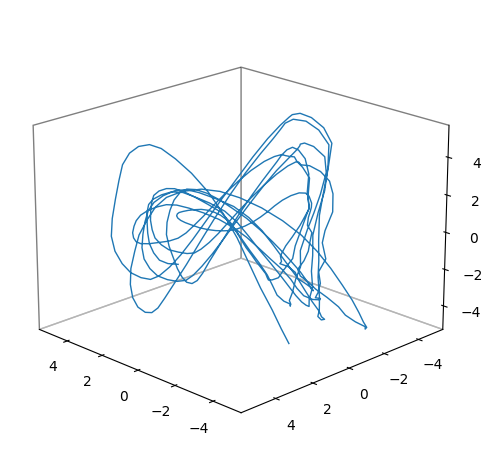

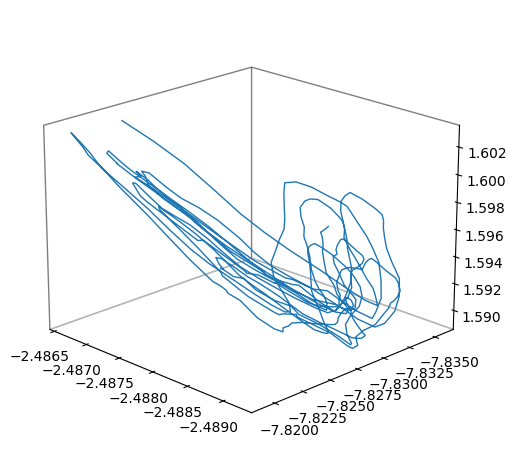

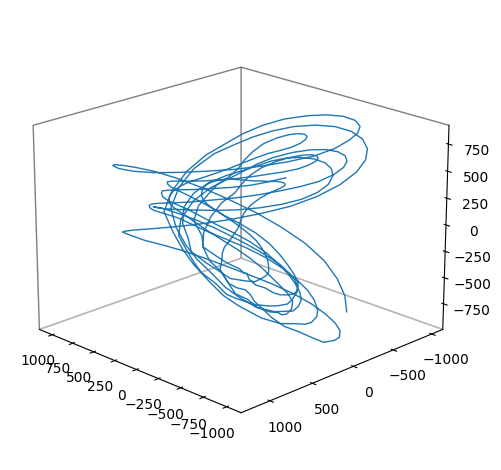

In [80]:
n_ts_train = 5
p = 3
nlags = 50

list_ts_train = list_ts[:n_ts_train]
theta_all_train = theta_all[:n_ts_train,:]

theta_all_test = theta_all[n_ts_train:,:]
list_ts_test = list_ts[n_ts_train:]

union_model = UnionDynamicRegression(nlags,p).fit(list_ts_train, theta_all_train)
model = MultilinearDynamicRegression(nlags,p).fit(list_ts_train, theta_all_train)

# i = 6
i = 5
ts_i, theta_i = list_ts_test[i], theta_all_test[i]

X_true = delay_embedding_matrix(ts_i, nlags)

tmp_model = PCA(model.params()['p']).fit(X_true)

S_true = tmp_model.transform(delay_embedding_matrix(ts_i, nlags))
# S_near =  model.transform(ts_i, theta_i, flg_near_model=True)
S_union =  union_model.transform(ts_i, theta_i)
S_suggest = model.transform(ts_i, theta_i)

_ = plot_phase_trajectory(phase_trajectory=S_true[300:700,:3], path='./../figure/fg_S_true.png')
# _ = plot_phase_trajectory(phase_trajectory=S_near[300:700,:3], path='./../figure/fg_S_near.png')
_ = plot_phase_trajectory(phase_trajectory=S_union[300:700,:3], path='./../figure/fg_S_union.png')
_ = plot_phase_trajectory(phase_trajectory=S_suggest[300:700,:3], path='./../figure/fg_S_suggest.png')